fuel model - penalizes for too low and to high velocities due to air resistance

fuel obj-  fuel-velocity , change in velocity, fuel consumed while stopping until you reach destination

multiple traffic lights

traffic - 
show - draw a diagram of the position and time of the vehicle, and the time bars for the red lights 

analysis - savings in fuel

---------------------------------------------------
limit for the acceleration max and min for stopping also 
minimizing fuel consumption only right now 
minimize jerk 
acceleration, derivative of acceleration 

quadratic speed decrease 

not consuming fuel when you hit breaks
current velocity plus current acceleration 

higher gears are more efficient 60miles per hour
discrete problem, for different gears different fuel efficiency 

is it different for truck or a car ? 

keep model simplified and add traffic lights 


In [15]:
start_x = 0
destination = 800     # meters
idle_fuel = 0.1/3600  # gallon per second
min_v = 6             # m/s
max_v = 19

min_a = -5
max_a = 5

n_lights = 3
traf_pos = [300, 500, 800]  # meters

T = 180               # seconds; upper bound 
t = [1:T;]

t_green_duration = [10, 10, 10]
t_red_duration = [24, 24, 24]

t_g = Array{Int64, 2}(n_lights, T)
t_r = Array{Int64, 2}(n_lights, T)

# generating arrays for traffic light phases, assumption starts with red light 
for k = 1:size(t_g, 1)
    if k%2 == 0
        for i=1:T
            j = i%(t_red_duration[k] + t_green_duration[k])
            if j<=(t_red_duration[k]-1)
                t_g[k, i] = t_red_duration[k] - j + 1
                t_r[k, i] = 0
            else
                t_g[k, i] = 0
                t_r[k, i] = t_green_duration[k] - j + t_red_duration[k]
            end
        end
    else 
        for i=1:T
            j = i%(t_red_duration[k] + t_green_duration[k])
            if j>(t_red_duration[k]-1)
                t_g[k, i] = t_red_duration[k] - j + 1
                t_r[k, i] = 0
            else
                t_g[k, i] = 0
                t_r[k, i] = t_green_duration[k] - j + t_red_duration[k]
            end
        end
    end
end

In [16]:
using JuMP, Gurobi

m = Model(solver=GurobiSolver(OutputFlag = 0))
@variable(m, x[1:T] >=0 )               # position at time t
@variable(m, 0 <= v[1:T] <= max_v)      # velocity at time t
@variable(m, min_a <= a[1:T-1] <= max_a)       # acceleration at time t 
@variable(m, obj_t[1:T])                # epigraph variable for fuel piecewise linear function 
@variable(m, w[1:T-1])
@variable(m, z_1[1:n_lights, 1:T], Bin)   # iff z1=1 then x[i] >= 965
@variable(m, z_2[1:n_lights, 1:T], Bin)   # iff z2=1 then x[i] <= 965
@variable(m, z_3[1:n_lights, 1:T], Bin)   # if z1=1 and z2=1 then z3 = 1; i.e. x[i] == 965
@variable(m, z_7[1:n_lights, 1:T], Bin)   # if x[i]>=946 then z7=1
@variable(m, z_8[1:n_lights, 1:T], Bin)   # if x[i]<=965 then z8=1
@variable(m, z_9[1:n_lights, 1:T], Bin)   # if z7=1 and z8=1 then z9=1
@variable(m, z_10[1:T], Bin)              # if v[i]<=0 then z_10 = 1

@variable(m, z_11[1:T], Bin)              # if x[i]<=destination then z_11 = 1

@constraint(m, dynamics[i in 1:T-1], x[i+1] == x[i] + a[i]/2 + v[i]) # per second, x = at^2*0.5 + vt
@constraint(m, velocity_change[i in 1:T-1], v[i+1] == v[i] + a[i])   # per second, v = v_initial + at 
@constraint(m, x[T] == destination)     # we need to reach destination 
@constraint(m, x[1] == start_x)
@constraint(m, v[1] == 0)
@constraint(m, v[T] == 0) 

# piecewise linear function for fuel 
@constraint(m, fuel_lin1[i in 1:T], obj_t[i] >= 0.00062*(-13/2*v[i]+59))
@constraint(m, fuel_lin2[i in 1:T], obj_t[i] >= 0.00062*7)
@constraint(m, fuel_lin3[i in 1:T], obj_t[i] >= 0.00062*(3/4*v[i]-17/4))

for i=1:T-1
    @constraint(m, w[i] >= a[i])
    @constraint(m, -w[i] <= a[i])
end

# Constraints for near the traffic light
for k = 1:n_lights
    for i=1:T
        @constraint(m, x[i] - (traf_pos[k]-max_v) <= traf_pos[k]*2*z_7[k, i] - 0.1*(1-z_7[k, i]))
        @constraint(m, x[i] - (traf_pos[k]-max_v) >= -(traf_pos[k]-max_v)*(1-z_7[k, i]))
        @constraint(m, x[i] - (traf_pos[k]) >= -(traf_pos[k])*z_8[k, i] + 0.1(1-z_8[k, i]))
        @constraint(m, x[i] - (traf_pos[k]) <= traf_pos[k]*2*(1-z_8[k, i]))
        @constraint(m, z_7[k, i] + z_8[k, i] - 2 <= 2*z_9[k, i] - (1-z_9[k, i]))
        @constraint(m, z_7[k, i] + z_8[k, i] - 2 >= -2*(1-z_9[k, i]))

        @constraint(m, x[i]- traf_pos[k] <= traf_pos[k]*2*z_1[k, i] - (1-z_1[k, i]))  # constraints for checking if x[i]==end_x
        @constraint(m, x[i] - traf_pos[k] >= -traf_pos[k]*(1-z_1[k, i]))
        @constraint(m, x[i]- traf_pos[k] >= -traf_pos[k]*z_2[k, i] + (1-z_2[k, i]))
        @constraint(m, x[i]- traf_pos[k] <= traf_pos[k]*2*(1-z_2[k, i])) 
        @constraint(m, z_1[k, i] + z_2[k, i] - 2 <= 2*z_3[k, i] - (1-z_3[k, i]))
        @constraint(m, z_1[k, i] + z_2[k, i] - 2 >= -2*(1-z_3[k, i]))

        for j=i:i+t_g[k, i]

            if j<=T
                @constraint(m, x[j]-(traf_pos[k]) <= 2*(traf_pos[k])*(1-z_9[k, i])) # if z9=1 then x[i+1] ... x[i+t_g[i]<=end_x
                @constraint(m, v[j] <= max_v*(1-z_3[k, i]))                # if z3=1 then v[j] = 0, last speed =0 when stops
            end
        end

        if k==1 && i>=2 && i <= T-1
            @constraint(m, v[i] >= -0.1*z_10[i]+(1-z_10[i]))
            @constraint(m, v[i] <= max_v*(1-z_10[i]))
        end
    end
end

for i=1:T
    @constraint(m, x[i] - (destination) >= -(destination)*z_11[i] + 0.1(1-z_11[i]))
    @constraint(m, x[i] - (destination) <= destination*2*(1-z_11[i]))
end

@expression(m, y1[i in 1:T], obj_t[i])
@expression(m, S1, sum(y1))
for i in 1:T
  @constraint(m, y1[i] <= 200*z_11[i])
end

@expression(m, y2[i in 1:T-1], w[i])
@expression(m, S2, sum(y2))
for i in 1:T-1
  @constraint(m, y2[i] <= max_a*z_11[i])
end

# Objective function: 
# 1) minimize fuel only until traffic light (z_8=1 if x[i]<=965)
# 2) minimize change in velocities until traffic light 
# 3) idle time: sum all the cases when v[i]==0
@objective(m, Min, sum(y1) + sum(y2) + 
                    sum(z_10[i] for i in 1:T)*idle_fuel)
#@objective(m, Min, sum(obj_t)+ sum(w) + sum(z_10)*idle_fuel)

solve(m)
vopt = getvalue(v)
xopt = getvalue(x)

println(getobjectivevalue(m))
println(sum(getvalue(a).^2))

for i=1:T
    if xopt[i] >= 298.914 - 0.1 && xopt[i] <= 298.914 + 0.1
        println(t_g[1, i], " T_GGG")
    end
    if xopt[i] >= 345.605 - 0.1 && xopt[i] <= 345.605 + 0.1
        println(t_g[2, i], " T_GGG")
    end
end

println("z11:", getvalue(z_11))
println()
println(t_g)
println()
println(xopt)
println()
println("z10=", sum(getvalue(z_10)))
println()
println(vopt)
println()
println(getvalue(z_3))

13.330549253731341
40.96591668523055
z11:[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 -1 -2 -3 -4 -5 -6 -7 -8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 -1 -2 -3 -4 -5 -6 -7 -8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 -1 -2 -3 -4 -5 -6 -7 -8 0 0 0 0 0

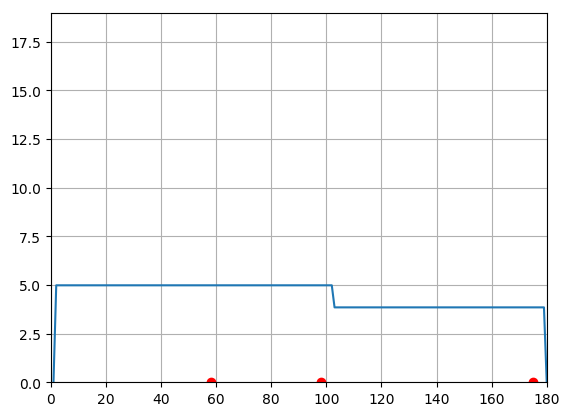

[58.0,98.0,175.0]


1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x325853f90>

In [17]:
using PyPlot
t = [1:T;]
grid("on")
ylim(0,max_v)
xlim(0,T)
plot(t, vopt)

time_at_light = zeros(n_lights)
for j = 1:n_lights
    for i=1:T
        if traf_pos[j]-max_v <= xopt[i] <= traf_pos[j] + max_v
            time_at_light[j] = i
            break
        end
    end
end
println(time_at_light)
plot(time_at_light, zeros(n_lights), "ro")

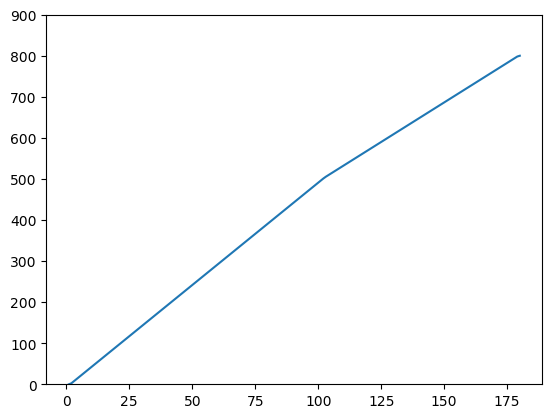

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x325c7c910>

In [18]:
# Plot of Position vs Time (includes waiting time's position)
ylim(0,destination+100)
plot(t,xopt)
#plot(t, traf_pos[2])

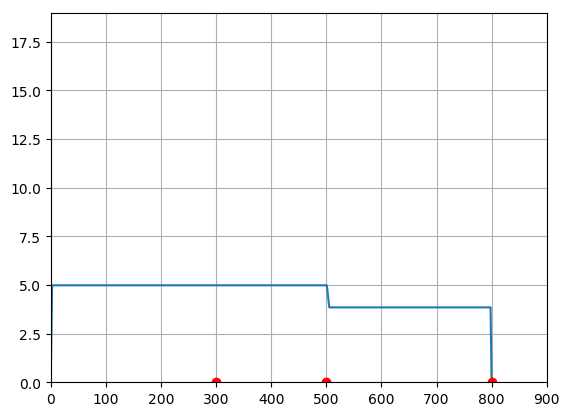

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32669cd90>

In [19]:
plot(xopt, vopt)
grid("on")
ylim(0,max_v)
xlim(0, destination+100)
plot(traf_pos, zeros(n_lights), "ro")